In [1]:
# Install required packages (if needed)
# !pip3 install pandas numpy matplotlib seaborn scikit-learn tqdm requests -q

In [2]:
# Ollama API setup and imports
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
import re
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference")

print("\n" + "=" * 80)
print("SETUP COMPLETE - FEW-SHOT INSIGHT GENERATION")
print("=" * 80)
print("Models configured:")
print("  • I4: Llama3.1:8b (Ollama - Local - Few-Shot)")
print("  • I5: Qwen3:8b (Ollama - Local - Few-Shot)")
print("  • I6: DeepSeek-R1:8b (Ollama - Local - Few-Shot)")
print("=" * 80)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference

SETUP COMPLETE - FEW-SHOT INSIGHT GENERATION
Models configured:
  • I4: Llama3.1:8b (Ollama - Local - Few-Shot)
  • I5: Qwen3:8b (Ollama - Local - Few-Shot)
  • I6: DeepSeek-R1:8b (Ollama - Local - Few-Shot)


## 1. Load Dataset

In [3]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
insights = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                insights.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_insight": insights})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nInsight distribution:")
print(df["true_insight"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Insight distribution:
true_insight
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_insight
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Few-Shot Examples

Carefully curated examples (2 positive, 2 negative, 1 neutral) representing typical financial insight patterns.

In [4]:
# Curated few-shot examples for INSIGHT GENERATION
FEW_SHOT_EXAMPLES = [
    {
        "sentence": "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007.",
        "insight": "positive",
        "rationale": "Operating profit increased significantly, indicating improved financial performance.",
    },
    {
        "sentence": "Net sales increased by 18.5% to EUR 167.8 million compared to the previous year.",
        "insight": "positive",
        "rationale": "Strong revenue growth of 18.5% signals business expansion and market success.",
    },
    {
        "sentence": "The company reported a net loss of EUR 2.5 million compared to a profit of EUR 1.2 million in the previous quarter.",
        "insight": "negative",
        "rationale": "Shift from profit to loss represents deteriorating financial health.",
    },
    {
        "sentence": "Sales decreased by 15% year-over-year due to weakening demand in key markets.",
        "insight": "negative",
        "rationale": "Significant sales decline indicates business challenges and market difficulties.",
    },
    {
        "sentence": "The company announced the appointment of a new chief financial officer effective next month.",
        "insight": "neutral",
        "rationale": "Executive appointment is routine corporate news without clear financial impact.",
    },
]

print("Few-Shot Examples for INSIGHT GENERATION:")
print("=" * 80)
for i, ex in enumerate(FEW_SHOT_EXAMPLES, 1):
    print(f"\nExample {i} [{ex['insight'].upper()}]:")
    print(f"Sentence: {ex['sentence']}")
    print(f"Insight: {ex['rationale']}")

Few-Shot Examples for INSIGHT GENERATION:

Example 1 [POSITIVE]:
Sentence: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007.
Insight: Operating profit increased significantly, indicating improved financial performance.

Example 2 [POSITIVE]:
Sentence: Net sales increased by 18.5% to EUR 167.8 million compared to the previous year.
Insight: Strong revenue growth of 18.5% signals business expansion and market success.

Example 3 [NEGATIVE]:
Sentence: The company reported a net loss of EUR 2.5 million compared to a profit of EUR 1.2 million in the previous quarter.
Insight: Shift from profit to loss represents deteriorating financial health.

Example 4 [NEGATIVE]:
Sentence: Sales decreased by 15% year-over-year due to weakening demand in key markets.
Insight: Significant sales decline indicates business challenges and market difficulties.

Example 5 [NEUTRAL]:
Sentence: The company announced the appointment of a new chief financial officer effective

## 3. Few-Shot Prompt Design

In [5]:
def create_few_shot_prompt(sentence):
    """
    Creates a few-shot prompt with 5 labeled examples for financial insight generation.
    """
    examples_text = ""
    for i, ex in enumerate(FEW_SHOT_EXAMPLES, 1):
        examples_text += f"""\nExample {i}:
Sentence: "{ex["sentence"]}"
Analysis:
{{
    "insight": "{ex["insight"]}",
    "confidence": 0.95,
    "rationale": "{ex["rationale"]}"
}}
"""

    prompt = f"""You are a financial insight analysis expert.

Classify the following financial statement as "positive", "negative", or "neutral" from an investor's perspective.

Guidelines:
- Positive: Good news for stock price (revenue increase, profit growth, expansion)
- Negative: Bad news for stock price (losses, declining sales, setbacks)
- Neutral: No clear impact or mixed signals

Here are 5 examples to learn from:
{examples_text}

Now classify this new statement:
Sentence: "{sentence}"

Provide your response in JSON format:
{{
    "insight": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation"
}}
"""
    return prompt


# Test prompt
test_sentence = "The company's quarterly revenue exceeded analyst expectations by 12%."
print("=" * 80)
print("FEW-SHOT PROMPT EXAMPLE (INSIGHT GENERATION)")
print("=" * 80)
print(create_few_shot_prompt(test_sentence)[:1000] + "...")

FEW-SHOT PROMPT EXAMPLE (INSIGHT GENERATION)
You are a financial insight analysis expert.

Classify the following financial statement as "positive", "negative", or "neutral" from an investor's perspective.

Guidelines:
- Positive: Good news for stock price (revenue increase, profit growth, expansion)
- Negative: Bad news for stock price (losses, declining sales, setbacks)
- Neutral: No clear impact or mixed signals

Here are 5 examples to learn from:

Example 1:
Sentence: "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
Analysis:
{
    "insight": "positive",
    "confidence": 0.95,
    "rationale": "Operating profit increased significantly, indicating improved financial performance."
}

Example 2:
Sentence: "Net sales increased by 18.5% to EUR 167.8 million compared to the previous year."
Analysis:
{
    "insight": "positive",
    "confidence": 0.95,
    "rationale": "Strong revenue growth of 18.5% signals business expansion and market success

## 4. Model Inference Functions

In [6]:
# Ollama API configuration
OLLAMA_BASE_URL = "http://localhost:11434/api/generate"


def call_ollama(model_name, prompt, temperature=0.0):
    """Generic function to call Ollama API for any model"""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = requests.post(
                OLLAMA_BASE_URL,
                json={
                    "model": model_name,
                    "prompt": prompt,
                    "temperature": temperature,
                    "stream": False,
                },
                timeout=120,
            )
            if response.status_code == 200:
                return response.json().get("response", "")
            else:
                if attempt < max_retries - 1:
                    time.sleep(2**attempt)
                    continue
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2**attempt)
                continue
            return None
    return None


def call_llama(prompt, temperature=0.0):
    """Call Llama3.1:8b via Ollama API (I4)"""
    return call_ollama("llama3.1:8b", prompt, temperature)


def call_qwen(prompt, temperature=0.0):
    """Call Qwen3:8b via Ollama API (I5)"""
    return call_ollama("qwen3:8b", prompt, temperature)


def call_deepseek(prompt, temperature=0.0):
    """Call DeepSeek-R1:8b via Ollama API (I6)"""
    return call_ollama("deepseek-r1:8b", prompt, temperature)


def parse_response(response_text):
    """Robustly parse JSON response, handling conversational filler and markdown blocks."""
    if not response_text:
        return None
    try:
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            match = re.search(r'(\{.*\})', response_text, re.DOTALL)
            if match:
                json_str = match.group(1).strip()
            else:
                json_str = response_text.strip()
        result = json.loads(json_str)
        if "sentiment" in result and "insight" not in result:
            result["insight"] = result["sentiment"]
        return result
    except Exception:
        response_lower = response_text.lower()
        if "positive" in response_lower and "negative" not in response_lower:
            return {"insight": "positive", "confidence": 0.5, "rationale": "Parsed from text"}
        elif "negative" in response_lower:
            return {"insight": "negative", "confidence": 0.5, "rationale": "Parsed from text"}
        elif "neutral" in response_lower:
            return {"insight": "neutral", "confidence": 0.5, "rationale": "Parsed from text"}
        return None


print("✓ Model inference functions defined")
print("  • call_llama() - Llama3.1:8b (I4)")
print("  • call_qwen() - Qwen3:8b (I5)")
print("  • call_deepseek() - DeepSeek-R1:8b (I6)")
print("  • parse_response() - JSON parser")

✓ Model inference functions defined
  • call_llama() - Llama3.1:8b (I4)
  • call_qwen() - Qwen3:8b (I5)
  • call_deepseek() - DeepSeek-R1:8b (I6)
  • parse_response() - JSON parser


## 5. Run Experiments

### I4: Llama3.1:8b (Few-Shot)

In [7]:
# Test sample (remove .head(200) for full run)
test_df = df.head(200).copy()

# I4: Llama3.1:8b
print("=" * 80)
print("Running I4: Llama3.1:8b (Few-Shot)")
print("=" * 80)
i4_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="I4 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_llama(prompt)

    if response:
        parsed = parse_response(response)
        if parsed:
            i4_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": parsed.get("insight", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            i4_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    else:
        i4_results.append(
            {
                "sentence": row["sentence"],
                "true_insight": row["true_insight"],
                "predicted_insight": "error",
                "confidence": 0,
                "rationale": "API call failed",
            }
        )

    time.sleep(0.5)

i4_df = pd.DataFrame(i4_results)
print(f"\n✓ I4 completed: {len(i4_df)} predictions")
print(f"  Valid predictions: {len(i4_df[i4_df['predicted_insight'].isin(['positive', 'negative', 'neutral'])])}")
print(f"  Errors: {len(i4_df[i4_df['predicted_insight'] == 'error'])}")
display(i4_df.head())

Running I4: Llama3.1:8b (Few-Shot)


I4 Progress: 100%|██████████| 200/200 [20:57<00:00,  6.29s/it]


✓ I4 completed: 200 predictions
  Valid predictions: 200
  Errors: 0


,sentence,true_insight,predicted_insight,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.80,The statement provides information about the c...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,Net sales doubled and a pre-tax loss was turne...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Strong revenue growth and significant increase...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,"Similar to example 1, operating profit increas..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit increased from EUR 18.6 mn to...


In [8]:
print("\nI4 Sample Results:")
print("\nTrue Risk Counts:")
print(i4_df['true_insight'].value_counts())
print("\nPredicted Risk Counts:")
print(i4_df['predicted_insight'].value_counts())


I4 Sample Results:

True Risk Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted Risk Counts:
predicted_insight
positive    189
neutral       6
negative      5
Name: count, dtype: int64


### I5: Qwen3:8b (Few-Shot)

In [9]:
# I5: Qwen3:8b
print("=" * 80)
print("Running I5: Qwen3:8b (Few-Shot)")
print("=" * 80)
i5_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="I5 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_qwen(prompt)

    if response:
        parsed = parse_response(response)
        if parsed:
            i5_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": parsed.get("insight", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            i5_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    else:
        i5_results.append(
            {
                "sentence": row["sentence"],
                "true_insight": row["true_insight"],
                "predicted_insight": "error",
                "confidence": 0,
                "rationale": "API call failed",
            }
        )

    time.sleep(0.5)

i5_df = pd.DataFrame(i5_results)
print(f"\n✓ I5 completed: {len(i5_df)} predictions")
print(f"  Valid predictions: {len(i5_df[i5_df['predicted_insight'].isin(['positive', 'negative', 'neutral'])])}")
print(f"  Errors: {len(i5_df[i5_df['predicted_insight'] == 'error'])}")
display(i5_df.head())

Running I5: Qwen3:8b (Few-Shot)


I5 Progress: 100%|██████████| 200/200 [1:46:12<00:00, 31.86s/it]


✓ I5 completed: 200 predictions
  Valid predictions: 200
  Errors: 0


,sentence,true_insight,predicted_insight,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.95,The statement indicates growth in Russia but l...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,"Net sales doubled, indicating strong revenue g..."
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Both net sales and operating profit showed sig...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Operating profit increased significantly to EU...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit increased from EUR 18.6 mn to...


In [10]:
print("\nI5 Sample Results:")
print("\nTrue Risk Counts:")
print(i5_df['true_insight'].value_counts())
print("\nPredicted Risk Counts:")
print(i5_df['predicted_insight'].value_counts())


I5 Sample Results:

True Risk Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted Risk Counts:
predicted_insight
positive    194
neutral       6
Name: count, dtype: int64


### I6: DeepSeek-R1:8b (Few-Shot)

In [11]:
# I6: DeepSeek-R1:8b
print("=" * 80)
print("Running I6: DeepSeek-R1:8b (Few-Shot)")
print("=" * 80)
i6_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="I6 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_deepseek(prompt)

    if response:
        parsed = parse_response(response)
        if parsed:
            i6_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": parsed.get("insight", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            i6_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    else:
        i6_results.append(
            {
                "sentence": row["sentence"],
                "true_insight": row["true_insight"],
                "predicted_insight": "error",
                "confidence": 0,
                "rationale": "API call failed",
            }
        )

    time.sleep(0.5)

i6_df = pd.DataFrame(i6_results)
print(f"\n✓ I6 completed: {len(i6_df)} predictions")
print(f"  Valid predictions: {len(i6_df[i6_df['predicted_insight'].isin(['positive', 'negative', 'neutral'])])}")
print(f"  Errors: {len(i6_df[i6_df['predicted_insight'] == 'error'])}")
display(i6_df.head())

Running I6: DeepSeek-R1:8b (Few-Shot)


I6 Progress: 100%|██████████| 200/200 [2:11:32<00:00, 39.46s/it]   


✓ I6 completed: 200 predictions
  Valid predictions: 200
  Errors: 0


,sentence,true_insight,predicted_insight,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.75,"The statement indicates growth in Russia, whic..."
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,Net sales doubled and the pre-tax loss was eli...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Both net sales and operating profit showed sig...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Operating profit increased significantly from ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit increased by 13.4% year-over-...


In [12]:
print("\nI6 Sample Results:")
print("\nTrue Risk Counts:")
print(i6_df['true_insight'].value_counts())
print("\nPredicted Risk Counts:")
print(i6_df['predicted_insight'].value_counts())


I6 Sample Results:

True Risk Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted Risk Counts:
predicted_insight
positive    187
neutral      12
negative      1
Name: count, dtype: int64


## 6. Calculate Metrics

In [13]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics including MCC"""
    if df.empty or "predicted_insight" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    valid_df = df[
        df["predicted_insight"].isin(["positive", "negative", "neutral"])
    ].copy()

    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_insight"]
    y_pred = valid_df["predicted_insight"]

    mcc_score = matthews_corrcoef(y_true, y_pred)

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": mcc_score,
    }

    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df


# Calculate metrics for all experiments
print("\n" + "=" * 80)
print("CALCULATING METRICS")
print("=" * 80)

i4_metrics, i4_cm, i4_valid = calculate_metrics(i4_df, "I4: Llama3.1:8b (Few-Shot)")
i5_metrics, i5_cm, i5_valid = calculate_metrics(i5_df, "I5: Qwen3:8b (Few-Shot)")
i6_metrics, i6_cm, i6_valid = calculate_metrics(i6_df, "I6: DeepSeek-R1:8b (Few-Shot)")

metrics_df = pd.DataFrame([i4_metrics, i5_metrics, i6_metrics])

print("\n" + "=" * 80)
print("FEW-SHOT INSIGHT GENERATION PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Valid Predictions", "Accuracy", "Macro-F1", "MCC"]
    ].round(4)
)

print("\n" + "=" * 80)
print("DETAILED METRICS")
print("=" * 80)
display(
    metrics_df[["Experiment", "Macro-Precision", "Macro-Recall", "Weighted-F1"]].round(4)
)

print("\n" + "=" * 80)
print("PER-CLASS F1 SCORES")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Positive_F1", "Negative_F1", "Neutral_F1"]
    ].round(4)
)


CALCULATING METRICS

FEW-SHOT INSIGHT GENERATION PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Experiment,Valid Predictions,Accuracy,Macro-F1,MCC
0,I4: Llama3.1:8b (Few-Shot),200,0.945,0.4459,0.3190
1,I5: Qwen3:8b (Few-Shot),200,0.995,0.9533,0.9105
2,I6: DeepSeek-R1:8b (Few-Shot),200,0.960,0.5224,0.6074



DETAILED METRICS


,Experiment,Macro-Precision,Macro-Recall,Weighted-F1
0,I4: Llama3.1:8b (Few-Shot),0.4409,0.4530,0.9587
1,I5: Qwen3:8b (Few-Shot),0.9167,0.9974,0.9952
2,I6: DeepSeek-R1:8b (Few-Shot),0.4722,0.6530,0.9693



PER-CLASS F1 SCORES


,Experiment,Positive_F1,Negative_F1,Neutral_F1
0,I4: Llama3.1:8b (Few-Shot),0.9740,0.0,0.3636
1,I5: Qwen3:8b (Few-Shot),0.9974,0.0,0.9091
2,I6: DeepSeek-R1:8b (Few-Shot),0.9791,0.0,0.5882


## 7. Visualize Results

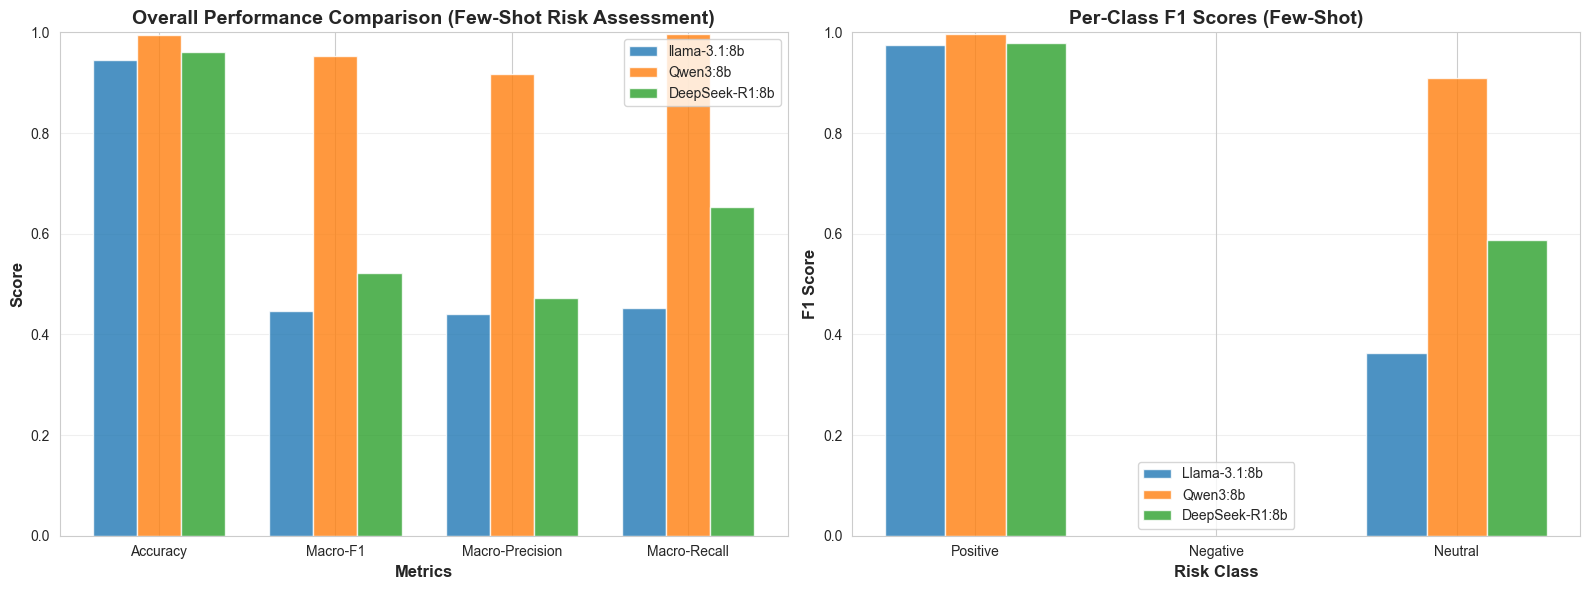

✓ Performance comparison chart saved


In [17]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (i4_metrics, "llama-3.1:8b"),
        (i5_metrics, "Qwen3:8b"),
        (i6_metrics, "DeepSeek-R1:8b"),
    ]
):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Few-Shot Risk Assessment)",
    fontsize=14,
    weight="bold",
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (i4_metrics, "Llama-3.1:8b"),
        (i5_metrics, "Qwen3:8b"),
        (i6_metrics, "DeepSeek-R1:8b"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Risk Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Few-Shot)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("few_shot_risk_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Performance comparison chart saved")

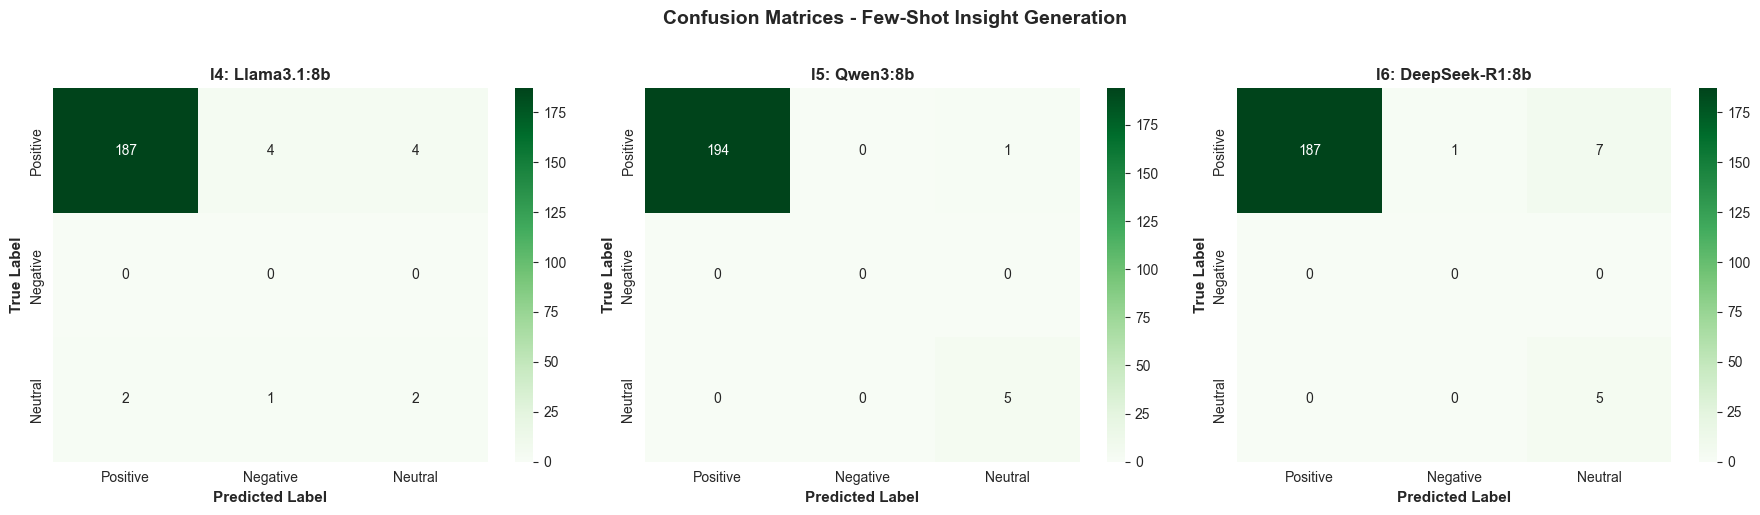

In [15]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (i4_cm, "I4: Llama3.1:8b"),
        (i5_cm, "I5: Qwen3:8b"),
        (i6_cm, "I6: DeepSeek-R1:8b"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Few-Shot Insight Generation",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("few_shot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 8. Save Results

In [16]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

i4_df.to_csv(f"i4_llama3.1_8b_few_shot_insight_{timestamp}.csv", index=False)
i5_df.to_csv(f"i5_qwen3_8b_few_shot_insight_{timestamp}.csv", index=False)
i6_df.to_csv(f"i6_deepseek_r1_8b_few_shot_insight_{timestamp}.csv", index=False)
metrics_df.to_csv(f"few_shot_insight_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Results saved with timestamp: {timestamp}")


✓ Results saved with timestamp: 20260217_025854


## 9. Error Analysis

In [19]:
def analyze_errors(df, model_name):
    """Analyze misclassification patterns"""
    errors = df[df["true_insight"] != df["predicted_insight"]].copy()

    print(f"=== Error Analysis for {model_name} ===\n")
    print(
        f"Total errors: {len(errors)}/{len(df)} ({len(errors) / len(df) * 100:.2f}%)\n"
    )

    # Misclassification patterns
    print("Misclassification patterns:")
    confusion_pairs = (
        errors.groupby(["true_insight", "predicted_insight"])
        .size()
        .sort_values(ascending=False)
    )
    for (true_label, pred_label), count in confusion_pairs.items():
        print(
            f"  {true_label} → {pred_label}: {count} ({count / len(errors) * 100:.1f}% of errors)"
        )

    # High-confidence errors (confidence > 0.7)
    if "confidence" in df.columns:
        high_conf_errors = errors[errors["confidence"] > 0.7]
        print(f"\nHigh-confidence errors (conf > 0.7): {len(high_conf_errors)}")
        if len(high_conf_errors) > 0:
            print("\nSample high-confidence errors:")
            for idx in high_conf_errors.head(3).index:
                row = df.loc[idx]
                print(
                    f"  True: {row['true_insight']} | Predicted: {row['predicted_insight']} | Confidence: {row['confidence']:.3f}"
                )
                print(f"  Text: {row['sentence'][:100]}...")
                print()

    # Sample errors by type
    print("\nSample misclassifications:")
    for (true_label, pred_label), _ in confusion_pairs.head(3).items():
        sample = errors[
            (errors["true_insight"] == true_label)
            & (errors["predicted_insight"] == pred_label)
        ].iloc[0]
        print(f"  {true_label} → {pred_label}:")
        print(f"  {sample['sentence'][:120]}...")
        print()

    return errors


# Analyze errors for each model
print("=== I4: Llama3.1:8b-Instruct Few-Shot ===")
i4_errors = analyze_errors(i4_valid, "I4: Llama3.1:8b")

print("\n" + "=" * 80 + "\n")
print("=== I5: Qwen3:8b-Versatile Few-Shot ===")
i5_errors = analyze_errors(i5_valid, "I5: Qwen3:8b")

print("\n" + "=" * 80 + "\n")
print("=== I6: DeepSeek-R1:8b Few-Shot ===")
i6_errors = analyze_errors(i6_valid, "I6: DeepSeek-R1:8b")

=== I4: Llama3.1:8b-Instruct Few-Shot ===
=== Error Analysis for I4: Llama3.1:8b ===

Total errors: 11/200 (5.50%)

Misclassification patterns:
  positive → negative: 4 (36.4% of errors)
  positive → neutral: 4 (36.4% of errors)
  neutral → positive: 2 (18.2% of errors)
  neutral → negative: 1 (9.1% of errors)

High-confidence errors (conf > 0.7): 4

Sample high-confidence errors:
  True: neutral | Predicted: positive | Confidence: 0.850
  Text: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCRE...

  True: neutral | Predicted: positive | Confidence: 0.800
  Text: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004...

  True: neutral | Predicted: negative | Confidence: 0.800
  Text: Tiimari operates 194 stores in six countries -- including its core Finnish market -- and generated a...


Sample misclassifications:
  positive → negative:
  Operating profit margin increased from 11.2 % to 1

## 10. Confidence Calibration Analysis

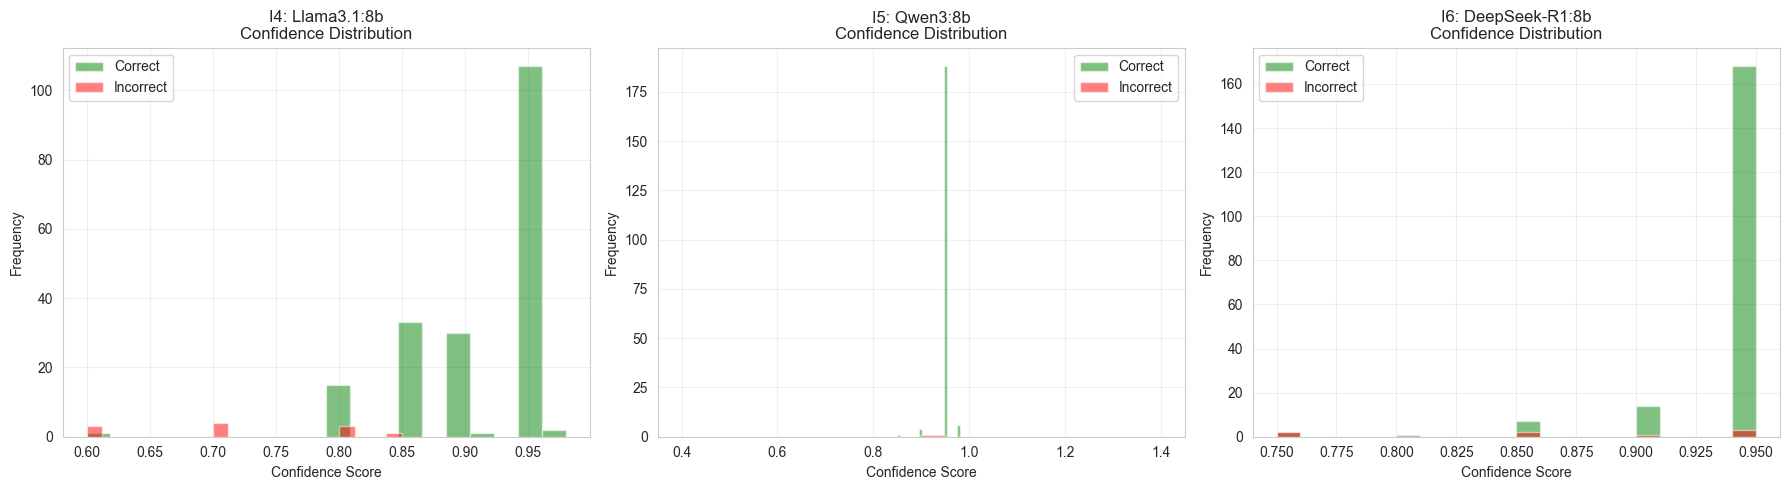

In [20]:
# Visualize confidence distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (valid_df, model_name) in enumerate(
    [
        (i4_valid, "I4: Llama3.1:8b"),
        (i5_valid, "I5: Qwen3:8b"),
        (i6_valid, "I6: DeepSeek-R1:8b"),
    ]
):
    if "confidence" in valid_df.columns:
        correct = valid_df["true_insight"] == valid_df["predicted_insight"]

        axes[idx].hist(
            valid_df[correct]["confidence"],
            bins=20,
            alpha=0.5,
            label="Correct",
            color="green",
        )
        axes[idx].hist(
            valid_df[~correct]["confidence"],
            bins=20,
            alpha=0.5,
            label="Incorrect",
            color="red",
        )
        axes[idx].set_xlabel("Confidence Score")
        axes[idx].set_ylabel("Frequency")
        axes[idx].set_title(f"{model_name}\nConfidence Distribution")
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
def analyze_confidence_calibration(df, model_name):
    """Analyze confidence calibration"""

    if "confidence" not in df.columns:
        print(f"No confidence scores for {model_name}")
        return

    # Overall calibration
    correct = df["true_insight"] == df["predicted_insight"]
    avg_conf_correct = df[correct]["confidence"].mean()
    avg_conf_incorrect = df[~correct]["confidence"].mean()
    calibration_gap = avg_conf_correct - avg_conf_incorrect

    print(f"=== Confidence Calibration: {model_name} ===\n")
    print(f"Average confidence when CORRECT: {avg_conf_correct:.3f}")
    print(f"Average confidence when INCORRECT: {avg_conf_incorrect:.3f}")
    print(f"Calibration gap: {calibration_gap:.3f}")
    print(
        f"  → {'Well-calibrated' if calibration_gap > 0.15 else 'Poorly calibrated'}\n"
    )

    # Per-class confidence
    print("Per-class average confidence:")
    for label in ["positive", "negative", "neutral"]:
        class_mask = df["predicted_insight"] == label
        if class_mask.sum() > 0:
            avg_conf = df[class_mask]["confidence"].mean()
            accuracy = (df[class_mask]["true_insight"] == label).mean()
            print(f"  {label}: {avg_conf:.3f} (accuracy: {accuracy:.3f})")


# Analyze confidence for each model
analyze_confidence_calibration(i4_valid, "I4: Llama3.1:8b")
print("\n" + "=" * 80 + "\n")
analyze_confidence_calibration(i5_valid, "I5: Qwen3:8b")
print("\n" + "=" * 80 + "\n")
analyze_confidence_calibration(i6_valid, "I6: DeepSeek-R1:8b")

=== Confidence Calibration: I4: Llama3.1:8b ===

Average confidence when CORRECT: 0.911
Average confidence when INCORRECT: 0.714
Calibration gap: 0.197
  → Well-calibrated

Per-class average confidence:
  positive: 0.912 (accuracy: 0.989)
  negative: 0.720 (accuracy: 0.000)
  neutral: 0.667 (accuracy: 0.333)


=== Confidence Calibration: I5: Qwen3:8b ===

Average confidence when CORRECT: 0.949
Average confidence when INCORRECT: 0.900
Calibration gap: 0.049
  → Poorly calibrated

Per-class average confidence:
  positive: 0.950 (accuracy: 1.000)
  neutral: 0.933 (accuracy: 0.833)


=== Confidence Calibration: I6: DeepSeek-R1:8b ===

Average confidence when CORRECT: 0.940
Average confidence when INCORRECT: 0.869
Calibration gap: 0.071
  → Poorly calibrated

Per-class average confidence:
  positive: 0.941 (accuracy: 1.000)
  negative: 0.900 (accuracy: 0.000)
  neutral: 0.883 (accuracy: 0.417)


## 11. Classification Reports

In [22]:
# Create per-class metrics summary table
from sklearn.metrics import precision_recall_fscore_support


def create_metrics_table(y_true, y_pred, model_name):
    """Create a summary table of per-class metrics"""
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=["positive", "negative", "neutral"]
    )

    metrics_df = pd.DataFrame(
        {
            "Class": ["positive", "negative", "neutral"],
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Support": support,
        }
    )

    print(f"\n{model_name} - Per-Class Metrics Summary:")
    print(metrics_df.to_string(index=False))
    return metrics_df


i4_class_metrics = create_metrics_table(
    i4_valid["true_insight"], i4_valid["predicted_insight"], "I4: Llama-3.1-8B"
)
i5_class_metrics = create_metrics_table(
    i5_valid["true_insight"], i5_valid["predicted_insight"], "I5: Qwen3:8b"
)
i6_class_metrics = create_metrics_table(
    i6_valid["true_insight"], i6_valid["predicted_insight"], "I6: DeepSeek-R1:8b"
)


I4: Llama-3.1-8B - Per-Class Metrics Summary:
   Class  Precision   Recall  F1-Score  Support
positive   0.989418 0.958974  0.973958      195
negative   0.000000 0.000000  0.000000        0
 neutral   0.333333 0.400000  0.363636        5

I5: Qwen3:8b - Per-Class Metrics Summary:
   Class  Precision   Recall  F1-Score  Support
positive   1.000000 0.994872  0.997429      195
negative   0.000000 0.000000  0.000000        0
 neutral   0.833333 1.000000  0.909091        5

I6: DeepSeek-R1:8b - Per-Class Metrics Summary:
   Class  Precision   Recall  F1-Score  Support
positive   1.000000 0.958974  0.979058      195
negative   0.000000 0.000000  0.000000        0
 neutral   0.416667 1.000000  0.588235        5


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and bein

In [23]:
from sklearn.metrics import classification_report

print("=" * 80)
print("R4: Llama3.1:8b Few-Shot Classification Report")
print("=" * 80)
print(
    classification_report(
        i4_valid["true_insight"],
        i4_valid["predicted_insight"],
        target_names=["negative", "neutral", "positive"],
    )
)

print("\n" + "=" * 80)
print("R5: Qwen3:8b Few-Shot Classification Report")
print("=" * 80)
print(
    classification_report(
        i5_valid["true_insight"],
        i5_valid["predicted_insight"],
        labels=["negative", "neutral", "positive"],
        target_names=["negative", "neutral", "positive"],
    )
)

print("\n" + "=" * 80)
print("R6: DeepSeek-R1:8b Few-Shot Classification Report")
print("=" * 80)
print(
    classification_report(
        i6_valid["true_insight"],
        i6_valid["predicted_insight"],
        target_names=["negative", "neutral", "positive"],
    )
)

R4: Llama3.1:8b Few-Shot Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.33      0.40      0.36         5
    positive       0.99      0.96      0.97       195

    accuracy                           0.94       200
   macro avg       0.44      0.45      0.45       200
weighted avg       0.97      0.94      0.96       200


R5: Qwen3:8b Few-Shot Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.83      1.00      0.91         5
    positive       1.00      0.99      1.00       195

    accuracy                           0.99       200
   macro avg       0.61      0.66      0.64       200
weighted avg       1.00      0.99      1.00       200


R6: DeepSeek-R1:8b Few-Shot Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to

## 12. Few-Shot vs Zero-Shot Comparison

Loading zero-shot metrics from: ../Zero_Shot/zero_shot_metrics_summary_20260216_223722.csv

Few-Shot vs Zero-Shot Performance Comparison
         Model  Zero-Shot Accuracy  Few-Shot Accuracy  Accuracy Improvement  Zero-Shot F1 (Macro)  Few-Shot F1 (Macro)  F1 Improvement
  Llama-3.1:8b            0.980000              0.945             -0.035000              0.661591             0.445865       -0.215726
      Qwen3:8b            0.979899              0.995              0.015101              0.851935             0.953260        0.101326
DeepSeek-R1:8b            0.955000              0.960              0.005000              0.492167             0.522431        0.030264


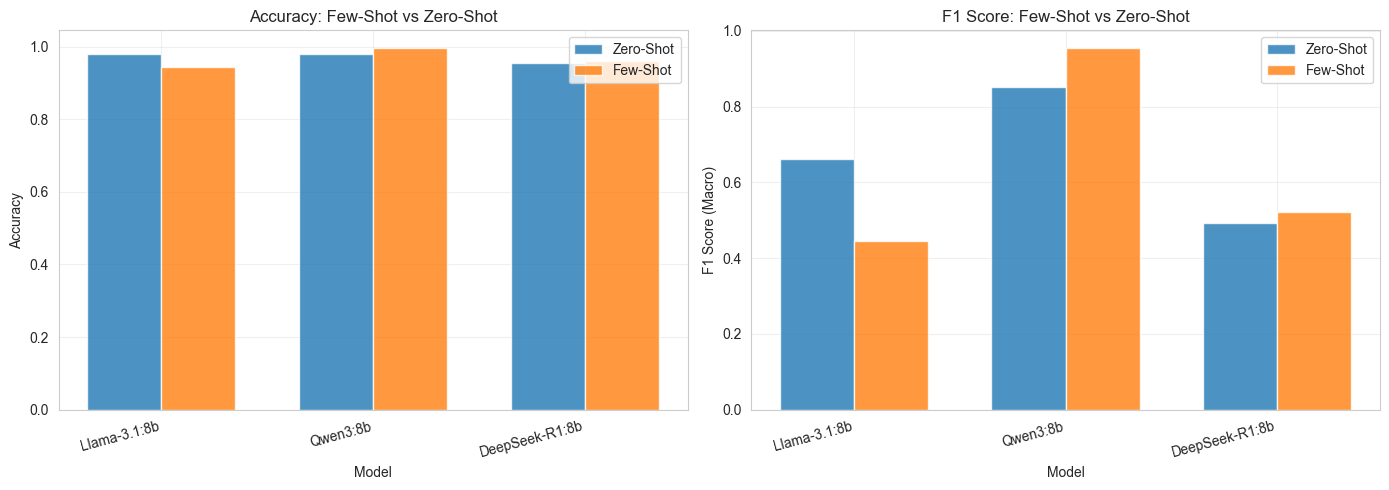


Key Insights from Few-Shot Learning:
1. Largest accuracy improvement: Qwen3:8b (+0.015)
2. Average accuracy improvement: +-0.005
3. 2/3 models improved with few-shot learning
4. F1 Score improvements range from -0.216 to 0.101


In [24]:
# Load zero-shot metrics summary for comparison
import os

try:
    # Try to find zero-shot metrics summary file
    zero_shot_dir = "../Zero_Shot/"
    if os.path.exists(zero_shot_dir):
        summary_files = [
            f
            for f in os.listdir(zero_shot_dir)
            if "metrics_summary" in f and f.endswith(".csv")
        ]
        if summary_files:
            zero_shot_summary_path = os.path.join(zero_shot_dir, summary_files[0])
            print(f"Loading zero-shot metrics from: {zero_shot_summary_path}")

            zero_shot_metrics_df = pd.read_csv(zero_shot_summary_path)
            few_shot_metrics_df = metrics_df.copy()

            # Compare metrics
            print("\n" + "=" * 80)
            print("Few-Shot vs Zero-Shot Performance Comparison")
            print("=" * 80)

            comparison_df = pd.DataFrame(
                {
                    "Model": ["Llama-3.1:8b", "Qwen3:8b", "DeepSeek-R1:8b"],
                    "Zero-Shot Accuracy": zero_shot_metrics_df["Accuracy"].values,
                    "Few-Shot Accuracy": few_shot_metrics_df["Accuracy"].values,
                    "Accuracy Improvement": few_shot_metrics_df["Accuracy"].values
                    - zero_shot_metrics_df["Accuracy"].values,
                    "Zero-Shot F1 (Macro)": zero_shot_metrics_df["Macro-F1"].values,
                    "Few-Shot F1 (Macro)": few_shot_metrics_df["Macro-F1"].values,
                    "F1 Improvement": few_shot_metrics_df["Macro-F1"].values
                    - zero_shot_metrics_df["Macro-F1"].values,
                }
            )

            print(comparison_df.to_string(index=False))

            # Visualize improvement
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            x = np.arange(len(comparison_df))
            width = 0.35

            # Accuracy comparison
            axes[0].bar(
                x - width / 2,
                comparison_df["Zero-Shot Accuracy"],
                width,
                label="Zero-Shot",
                alpha=0.8,
            )
            axes[0].bar(
                x + width / 2,
                comparison_df["Few-Shot Accuracy"],
                width,
                label="Few-Shot",
                alpha=0.8,
            )
            axes[0].set_xlabel("Model")
            axes[0].set_ylabel("Accuracy")
            axes[0].set_title("Accuracy: Few-Shot vs Zero-Shot")
            axes[0].set_xticks(x)
            axes[0].set_xticklabels(comparison_df["Model"], rotation=15, ha="right")
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)

            # F1 comparison
            axes[1].bar(
                x - width / 2,
                comparison_df["Zero-Shot F1 (Macro)"],
                width,
                label="Zero-Shot",
                alpha=0.8,
            )
            axes[1].bar(
                x + width / 2,
                comparison_df["Few-Shot F1 (Macro)"],
                width,
                label="Few-Shot",
                alpha=0.8,
            )
            axes[1].set_xlabel("Model")
            axes[1].set_ylabel("F1 Score (Macro)")
            axes[1].set_title("F1 Score: Few-Shot vs Zero-Shot")
            axes[1].set_xticks(x)
            axes[1].set_xticklabels(comparison_df["Model"], rotation=15, ha="right")
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Key insights from comparison
            print("\n" + "=" * 80)
            print("Key Insights from Few-Shot Learning:")
            print("=" * 80)

            best_improvement = comparison_df.loc[
                comparison_df["Accuracy Improvement"].idxmax()
            ]
            print(
                f"1. Largest accuracy improvement: {best_improvement['Model']} (+{best_improvement['Accuracy Improvement']:.3f})"
            )

            avg_improvement = comparison_df["Accuracy Improvement"].mean()
            print(f"2. Average accuracy improvement: +{avg_improvement:.3f}")

            if (comparison_df["Accuracy Improvement"] > 0).all():
                print("3. All models benefited from few-shot examples")
            else:
                print(
                    f"3. {(comparison_df['Accuracy Improvement'] > 0).sum()}/3 models improved with few-shot learning"
                )

            print(
                f"4. F1 Score improvements range from {comparison_df['F1 Improvement'].min():.3f} to {comparison_df['F1 Improvement'].max():.3f}"
            )

        else:
            print("No zero-shot metrics summary file found - skipping comparison")
    else:
        print(f"Zero-shot directory not found: {zero_shot_dir} - skipping comparison")

except Exception as e:
    print(f"Could not load zero-shot metrics for comparison: {e}")
    print("Skipping few-shot vs zero-shot comparison")

## 9. Key Insights

### Few-Shot Learning Impact:

1. **Learning from Examples**: Compare performance improvements vs zero-shot
2. **Model Comparison**: Which model benefits most from examples?
3. **Example Quality**: How do curated examples influence predictions?
4. **Confidence Calibration**: Are models more confident with examples?